In [1]:
import numpy as np
import pandas as pd

import time
import math
import gzip

from IPython.display import display

#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.market.plots import *
from functions.preprocessing import *
from functions.evaluation import *

In [2]:
# set some default values
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams.update({'font.size': 16})

In [3]:
# df = pd.read_csv('./data/kraken/xbt_usd/ss_2019-03-08.csv.gz', compression='gzip', header=None)
data = np.loadtxt('./data/kraken/eth_eur/ss_2019-03-16.csv.gz', delimiter=',')

depth = 100

In [4]:
dataset = pd.DataFrame()

dataset["vwap"] = [calc_VWAP(ss) for ss in data]
dataset["wamp"] = [calc_WAMP(ss) for ss in data]

dataset["ask_c_vol"] = pd.DataFrame([vs.sum() for vs in data[:, 1:depth * 3:3]]).rolling(50).mean()
dataset["bid_c_vol"] = pd.DataFrame([vs.sum() for vs in data[:, 301:300 + depth * 3:3]]).rolling(50).mean()

dataset["ask_max"] = pd.DataFrame([ask for ask in data[:, (depth-1)*3]]).rolling(10).mean()
dataset["bid_min"] = pd.DataFrame([bid for bid in data[:, -4]]).rolling(10).mean()

dataset["ma_10"] = dataset["vwap"].rolling(window=10).mean()
dataset["ma_50"] = dataset["vwap"].rolling(window=50).mean()

# https://www.investopedia.com/terms/m/macd.asp
# https://www.portfolio.hu/vallalatok/technikai-elemzes/mit-mutat-az-macd.89286.html

# Exponential Moving Average (EMA)
dataset['ema_26'] = dataset['vwap'].ewm(span=26).mean()
dataset['ema_12'] = dataset['vwap'].ewm(span=12).mean()
# Moving Average Convergence Divergence (MACD)
dataset['MACD'] = (dataset['ema_12']-dataset['ema_26'])
dataset['MACD_9'] = dataset['MACD'].ewm(span=9).mean()

# https://www.investopedia.com/terms/b/bollingerbands.asp
# Create Bollinger Bands std_window = 2*mean_window
dataset['20std'] = dataset["vwap"].rolling(20).std()
dataset['upper_band'] = dataset['ma_10'] + (dataset['20std']*2)
dataset['lower_band'] = dataset['ma_10'] - (dataset['20std']*2)

# safety cut to remove columns which don't have values (because of rolling)
dataset = dataset[100:].reset_index(drop=True)
data = data[100:]

In [5]:
dataset.head()

,vwap,wamp,ask_c_vol,bid_c_vol,ask_max,bid_min,ma_10,ma_50,ema_26,ema_12,MACD,MACD_9,20std,upper_band,lower_band
0,120.909535,121.649524,7024.12660,6529.74478,123.454,116.382,120.710488,120.434950,120.655830,120.756339,0.100509,0.107937,0.126099,120.962686,120.458289
1,121.033756,121.773157,6959.68386,6531.69940,123.462,116.400,120.734347,120.456710,120.683835,120.799018,0.115183,0.109386,0.140989,121.016326,120.452369
2,121.051773,121.771966,6924.26814,6537.66274,123.479,116.424,120.779824,120.478487,120.711100,120.837904,0.126804,0.112870,0.151214,121.082251,120.477397
3,121.127047,121.840000,6885.24948,6554.05366,123.486,116.442,120.832097,120.502045,120.741921,120.882387,0.140466,0.118389,0.169094,121.170284,120.493909
4,121.124185,121.878901,6847.29304,6556.85308,123.510,116.455,120.889912,120.526305,120.770246,120.919587,0.149341,0.124579,0.183455,121.256822,120.523001


Timestamp:	 2019/03/16 01:42:26
Mid-price:	 121.65
Spread:		 0.060000000000002274
WAMP:		 121.64952380952381
VWAP:		 120.90953549707018


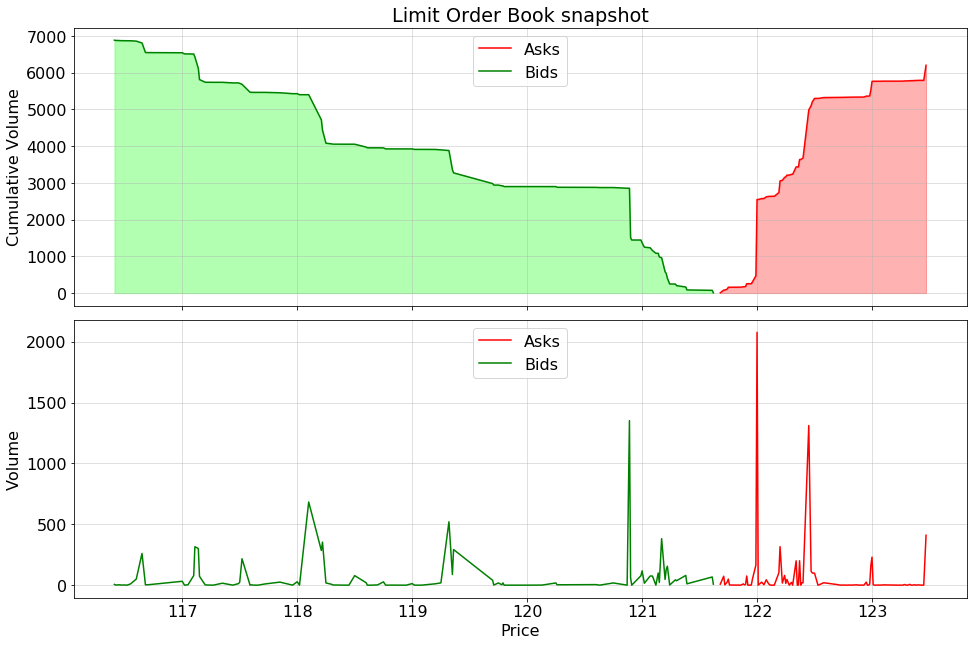

In [6]:
snapshot = data[0]

print('Timestamp:\t', time.strftime('%Y/%m/%d %H:%M:%S',  time.gmtime(snapshot[600])))
print('Mid-price:\t', calc_mid_price(snapshot))
print('Spread:\t\t', calc_spread(snapshot))
print('WAMP:\t\t', calc_WAMP(snapshot))
print('VWAP:\t\t', calc_VWAP(snapshot))

plot_LOB(snapshot, 100)

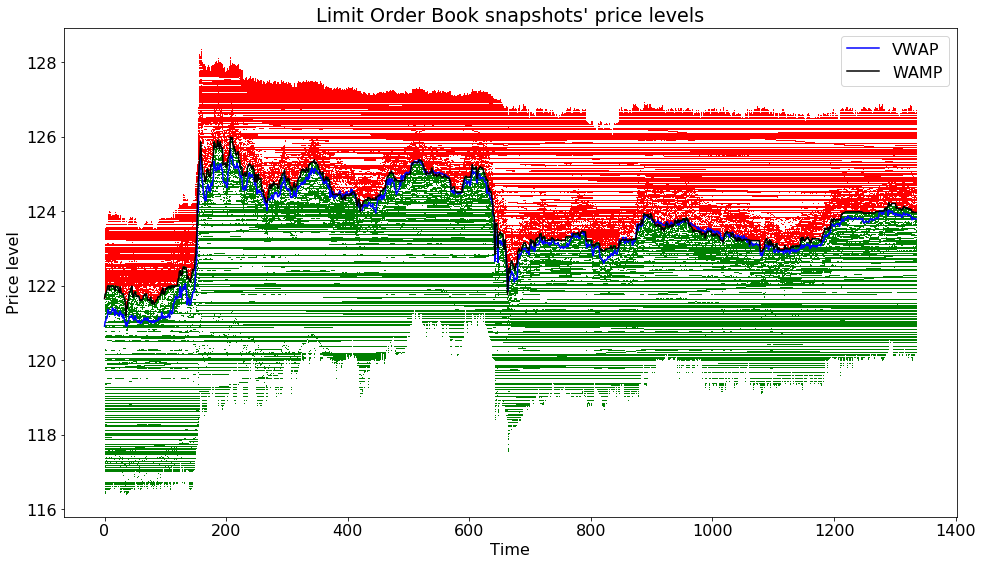

In [7]:
fig, ax = plt.subplots(figsize = (16, 9))

# depth = 100, 1 entry has 3 values (price, volume, timestamp) and the LOB has 2 sides
for i in range(len(data[0,:depth*3*2:3])):
    if i < depth:
        marker = 'r,'
    else:
        marker = 'g,'
    ax.plot(data[:, i*3], marker)
    
ax.plot(dataset["vwap"], label="VWAP", color="b")
ax.plot(dataset["wamp"], label="WAMP", color="black")

ax.set_title("Limit Order Book snapshots' price levels")    
ax.set_xlabel("Time")
ax.set_ylabel("Price level")
ax.legend()

plt.show()

Timestamp:	 2019/03/16


,WAMP,VWAP
Open,121.649524,120.909535
High,125.985989,125.674431
Low,121.200045,120.909535
Close,123.964346,123.788502
Volatility,1.029439,1.108640


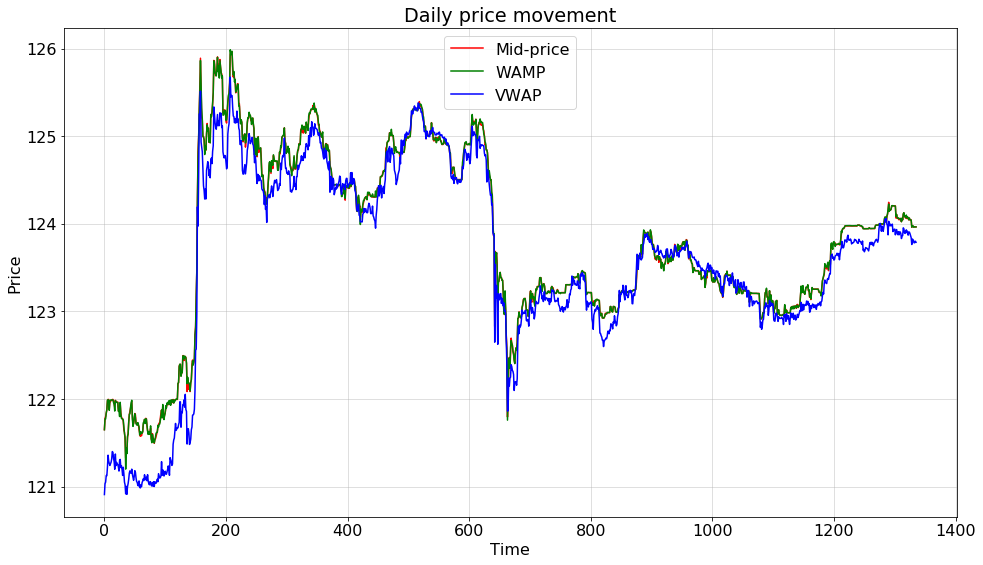

In [8]:
print('Timestamp:\t', time.strftime('%Y/%m/%d',  time.gmtime(data[0][600])))

metrics = {
    'Open': [dataset["wamp"].iloc[0], dataset["vwap"].iloc[0]],
    'High': [np.amax(dataset["wamp"]), np.amax(dataset["vwap"])],
    'Low': [np.amin(dataset["wamp"]), np.amin(dataset["vwap"])],
    'Close': [dataset["wamp"].iloc[-1], dataset["vwap"].iloc[-1]],
    'Volatility': [calc_volatility(dataset["wamp"]), calc_volatility(dataset["vwap"])]
}

df = pd.DataFrame.from_dict(metrics, orient='index', columns=['WAMP', 'VWAP'])

display(df)

plot_price_movement(data)

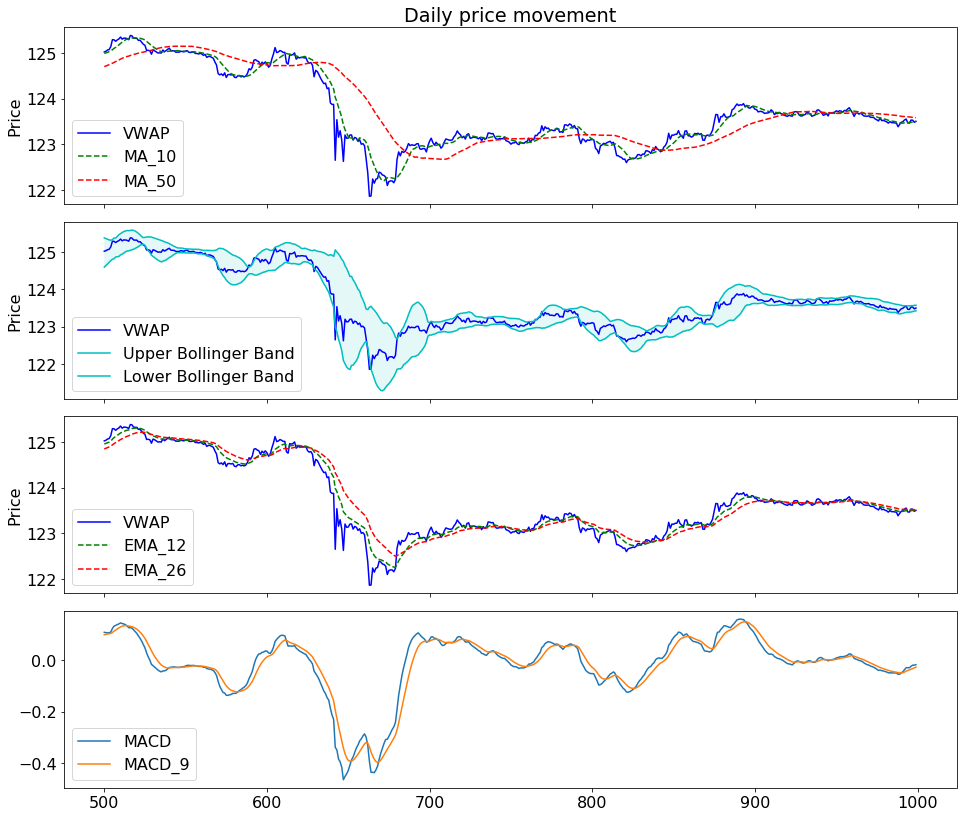

In [9]:
slice_ = slice(500, 1000, 1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize = (16, 12))
fig.subplots_adjust(hspace=0.1, bottom=0.0)

# plot vwap for all
ax1.plot(dataset[slice_]["vwap"], label="VWAP", color='b')
ax2.plot(dataset[slice_]["vwap"], label="VWAP", color='b')
ax3.plot(dataset[slice_]["vwap"], label="VWAP", color='b')

# plot the other metrics
ax1.plot(dataset[slice_]["ma_10"], label="MA_10", linestyle='--', c='g')
ax1.plot(dataset[slice_]["ma_50"], label="MA_50", linestyle='--', c='r')

ax2.plot(dataset[slice_]["upper_band"], label="Upper Bollinger Band", color='c')
ax2.plot(dataset[slice_]["lower_band"], label="Lower Bollinger Band", color='c')
ax2.fill_between(list(dataset[slice_].index), dataset[slice_]["upper_band"], dataset[slice_]["lower_band"], color='c', alpha=0.1)

ax3.plot(dataset[slice_]["ema_12"], label="EMA_12", linestyle='--', c='g')
ax3.plot(dataset[slice_]["ema_26"], label="EMA_26", linestyle='--', c='r')

ax4.plot(dataset[slice_]["MACD"], label="MACD")
ax4.plot(dataset[slice_]["MACD_9"], label="MACD_9")

ax1.set_ylabel('Price')
ax1.set_title('Daily price movement')

ax2.set_ylabel('Price')

ax3.set_ylabel('Price')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

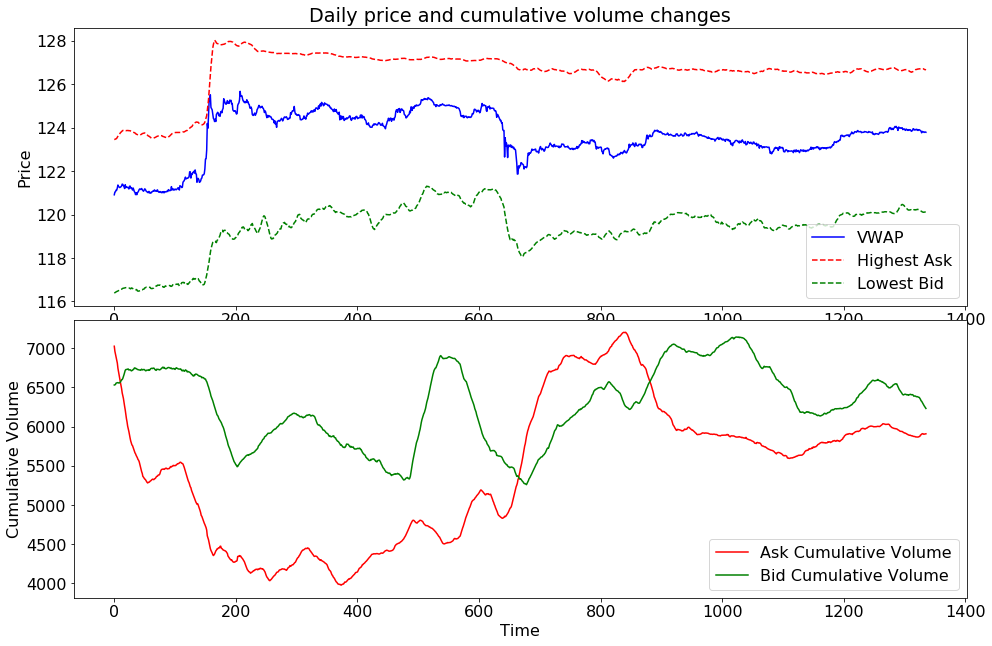

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (16, 9))
fig.subplots_adjust(hspace=0.05, bottom=0.0)

ax1.plot(dataset["vwap"], label="VWAP", color='b')
ax1.plot(dataset["ask_max"], label="Highest Ask", linestyle='--', color='r')
ax1.plot(dataset["bid_min"], label="Lowest Bid", linestyle='--', color='g')

ax1.set_ylabel('Price')
ax1.set_title("Daily price and cumulative volume changes")


ax2.plot(dataset["ask_c_vol"], label="Ask Cumulative Volume", linestyle='-', c='r')
ax2.plot(dataset["bid_c_vol"], label="Bid Cumulative Volume", linestyle='-', c='g')

ax2.set_xlabel("Time")
ax2.set_ylabel("Cumulative Volume")

ax1.legend()
ax2.legend()

plt.show()